In [ ]:
!pip install pyModeS pandas matplotlib

In [2]:
import pyModeS as pyms
import pandas as pd
import matplotlib.pyplot as plt

# Let's load some sample data.

In [3]:
data = pd.read_csv("https://github.com/junzis/tutorial-icrat24-adsb/raw/main/data/samples.csv", names=["timestamp", "message"])

data

,timestamp,message
0,1.568018e+09,8D4C01E45805B649D8EDDF517B23
1,1.568018e+09,0246009B4584F0
2,1.568018e+09,5D4C01E4BC9DD0
3,1.568018e+09,0241009C9B7913
4,1.568018e+09,8D4C01E45805C2DE80F4AAF961B3
...,...,...
7748,1.568020e+09,5D4C01E4BC9DF0
7749,1.568020e+09,5D4C01E4BC9DCC
7750,1.568020e+09,02E1979FF80121
7751,1.568020e+09,02E6179F203CC2


## Which aircraft broadcasted these messages?
We need to indentify the transponder address.

In [4]:
data["icao"] = data.message.apply(pyms.icao)

data

,timestamp,message,icao
0,1.568018e+09,8D4C01E45805B649D8EDDF517B23,4C01E4
1,1.568018e+09,0246009B4584F0,4C01E4
2,1.568018e+09,5D4C01E4BC9DD0,4C01E4
3,1.568018e+09,0241009C9B7913,4C01E4
4,1.568018e+09,8D4C01E45805C2DE80F4AAF961B3,4C01E4
...,...,...,...
7748,1.568020e+09,5D4C01E4BC9DF0,4C01E4
7749,1.568020e+09,5D4C01E4BC9DCC,4C01E4
7750,1.568020e+09,02E1979FF80121,4C01E4
7751,1.568020e+09,02E6179F203CC2,4C01E4


## What kind of messages are we looking at?

In [5]:
# Compute the Downlink Format
data["DF"] = data.message.apply(pyms.df)

data

,timestamp,message,icao,DF
0,1.568018e+09,8D4C01E45805B649D8EDDF517B23,4C01E4,17
1,1.568018e+09,0246009B4584F0,4C01E4,0
2,1.568018e+09,5D4C01E4BC9DD0,4C01E4,11
3,1.568018e+09,0241009C9B7913,4C01E4,0
4,1.568018e+09,8D4C01E45805C2DE80F4AAF961B3,4C01E4,17
...,...,...,...,...
7748,1.568020e+09,5D4C01E4BC9DF0,4C01E4,11
7749,1.568020e+09,5D4C01E4BC9DCC,4C01E4,11
7750,1.568020e+09,02E1979FF80121,4C01E4,0
7751,1.568020e+09,02E6179F203CC2,4C01E4,0


Recall the downlink format
```
DF 0: Short air-air surveillance
DF 4: Surveillance, altitude reply
DF 5: Surveillance, identity reply
DF 11: All call reply
DF 16: Long air-air surveillance
DF 17: Extended squitter
DF 18: Extended squitter/non transponder
DF 19: Military extended squitter
DF 20: Comm-B, altitude reply
DF 21: Comm-B, identity reply
DF 24: Comm-D (Extended Length Message)
```

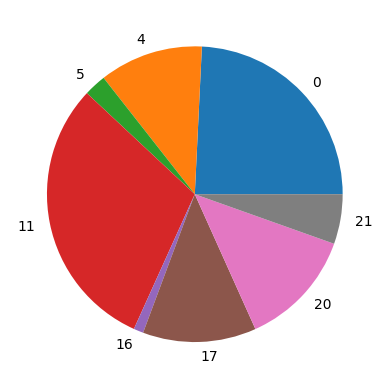

In [6]:
# Analyze the distributions of downlink format among messages
data.groupby("DF").size().plot(kind="pie")
plt.show()

---
# Work with different types of ADS-B messages

## Filter out all the ADS-B messages

In [7]:
adsb = data[data.DF == 17].copy()

adsb

,timestamp,message,icao,DF
0,1.568018e+09,8D4C01E45805B649D8EDDF517B23,4C01E4,17
4,1.568018e+09,8D4C01E45805C2DE80F4AAF961B3,4C01E4,17
6,1.568018e+09,8D4C01E499440793008802D2D79C,4C01E4,17
11,1.568018e+09,8D4C01E45805E6499CEDDEE1391C,4C01E4,17
15,1.568018e+09,8D4C01E499440793008802D2D79C,4C01E4,17
...,...,...,...,...
7688,1.568020e+09,8D4C01E4994143AA48080394EBAD,4C01E4,17
7705,1.568020e+09,8D4C01E4994142AA480403DFBB63,4C01E4,17
7715,1.568020e+09,8D4C01E4994142AA48080397E163,4C01E4,17
7745,1.568020e+09,8D4C01E458BDF4D30BE304169D14,4C01E4,17


## What do these ADS-B message tell us?
We need to find out the **Type Code** of the messages, recall that:
```
TC=1-4:    Identity message
TC=5-8:    Surface movement message
TC=9-18:   Airborn position message (with barometric altitude)
TC=19:     Airborne velocity message
TC=20-22:  Airborn position message (with GNSS altitude)
```

In [8]:
adsb["TC"] = adsb.message.apply(pyms.adsb.typecode)

adsb.head(20)

,timestamp,message,icao,DF,TC
0,1.568018e+09,8D4C01E45805B649D8EDDF517B23,4C01E4,17,11
4,1.568018e+09,8D4C01E45805C2DE80F4AAF961B3,4C01E4,17,11
6,1.568018e+09,8D4C01E499440793008802D2D79C,4C01E4,17,19
11,1.568018e+09,8D4C01E45805E6499CEDDEE1391C,4C01E4,17,11
15,1.568018e+09,8D4C01E499440793008802D2D79C,4C01E4,17,19
18,1.568018e+09,8D4C01E499440793008C03151595,4C01E4,17,19
20,1.568018e+09,8D4C01E45805F64984EDDD9D9BF6,4C01E4,17,11
22,1.568018e+09,8D4C01E499440792E09402742819,4C01E4,17,19
25,1.568018e+09,8D4C01E4580702DE2AF4A88E9702,4C01E4,17,11
34,1.568018e+09,8D4C01E499440792E09402742819,4C01E4,17,19


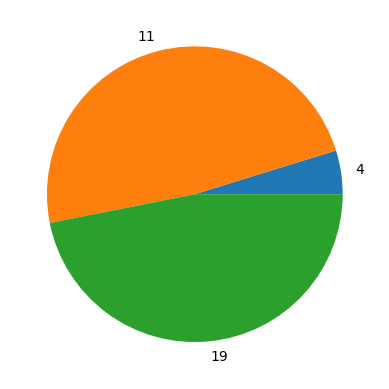

In [9]:
adsb.groupby("TC").size().plot(kind="pie")
plt.show()

---
## Aircraft indentity
Let's take a look at the following identity message:
```
              timestamp                       message    icao  DF  TC
104 1568017740.09914660  8D4C01E420053332C1A8207D484C  4C01E4  17   4
```

In [10]:
pyms.adsb.callsign("8D4C01E420053332C1A8207D484C")

'ASL20Z__'

---
## Aircraft velocity (airborne)
Let's take a look at the following airborne velocity message:
```
              timestamp                       message    icao  DF  TC
15  1568017732.67249036  8D4C01E499440793008802D2D79C  4C01E4  17  19
```

In [11]:
pyms.adsb.velocity("8D4C01E499440793008802D2D79C")

# speed (kt), heading (degree), vertical rate (fpm), 'GS'or'TAS'

(151, 182.2754564382542, 2112, 'GS')

---
## Aircraft position (airborne)
There two ways to decode aircraft messages:
1. Decode with **two messages** (odd and even position frame)
2. Decode with **one message with a reference position** (once aircraft is lock through 1)

In [12]:
# compute the "odd/even" indicator
positions = adsb[adsb.TC.between(5, 18)].copy()
positions["oe"] = positions.message.apply(pyms.adsb.oe_flag)
positions.head(15)

,timestamp,message,icao,DF,TC,oe
0,1.568018e+09,8D4C01E45805B649D8EDDF517B23,4C01E4,17,11,1
4,1.568018e+09,8D4C01E45805C2DE80F4AAF961B3,4C01E4,17,11,0
11,1.568018e+09,8D4C01E45805E6499CEDDEE1391C,4C01E4,17,11,1
20,1.568018e+09,8D4C01E45805F64984EDDD9D9BF6,4C01E4,17,11,1
25,1.568018e+09,8D4C01E4580702DE2AF4A88E9702,4C01E4,17,11,0
73,1.568018e+09,8D4C01E4580762DDB2F4A608CC43,4C01E4,17,11,0
84,1.568018e+09,8D4C01E4580782DD9AF4A6FA6B2B,4C01E4,17,11,0
94,1.568018e+09,8D4C01E458079648C6EDDA6EB43C,4C01E4,17,11,1
104,1.568018e+09,8D4C01E458079648BAEDD9DA6F49,4C01E4,17,11,1
117,1.568018e+09,8D4C01E45807B2DD5EF4A4FC2FEB,4C01E4,17,11,0


### Decoding with two messages (globally unambiguous position)
```
              timestamp                       message    icao  DF  TC  oe
9   1568017731.14865947  8D4C01E45805B649D8EDDF517B23  4C01E4  17  11   1
13  1568017732.07376266  8D4C01E45805C2DE80F4AAF961B3  4C01E4  17  11   0
```

In [13]:
pyms.adsb.position(
    "8D4C01E45805C2DE80F4AAF961B3",
    "8D4C01E45805B649D8EDDF517B23",
    1568017732,
    1568017731,
)
# latutude, longitude

(52.3037109375, 4.778594970703125)

### Decoding with one message (locally unambiguous position)
```
              timestamp                       message    icao  DF  TC  oe
20  1568017733.05163741  8D4C01E45805E6499CEDDEE1391C  4C01E4  17  11   1
```
Considering position (-51.71628, -2.55447) from previous example

In [14]:
pyms.adsb.position_with_ref("8D4C01E45805E6499CEDDEE1391C", 52.30371, 4.77859)
# latutude, longitude

(52.30302196438029, 4.778581891741072)

---
# Decode all positions and velocities

In [15]:
positions = []
velocities = []


lat, lon = (52.30302, 4.77858)
for idx, row in adsb[adsb.TC.between(5, 18)].iterrows():
    lat, lon = pyms.adsb.position_with_ref(row.message, lat_ref=lat, lon_ref=lon)
    alt = pyms.adsb.altitude(row.message)
    positions.append((row.timestamp, lat, lon, alt))

for idx, row in adsb[adsb.TC == 19].iterrows():
    spd, trk, vs, label = pyms.adsb.velocity(row.message)
    velocities.append((row.timestamp, spd, trk, vs))

In [16]:
t1, lat, lon, alt = zip(*positions)
t2, spd, trk, vs = zip(*velocities)

Next, we will visualize all the positions, velocities, and altitudes from the decoded messages.

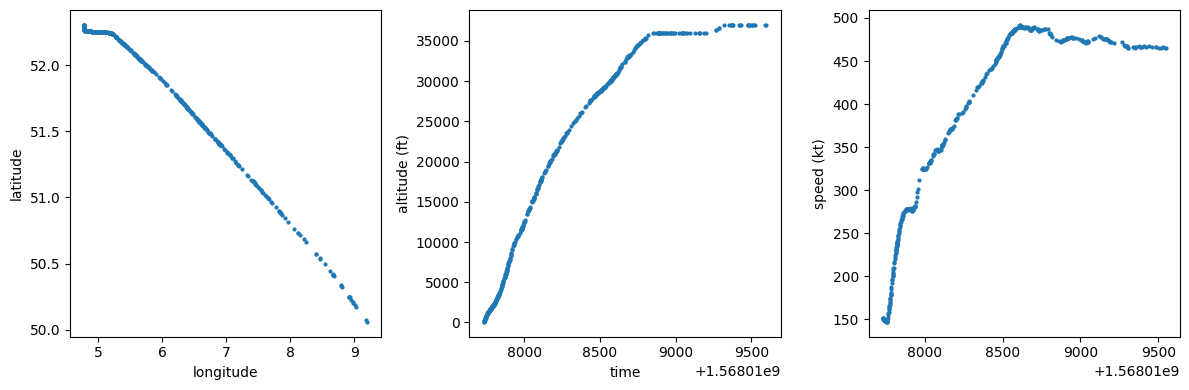

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(lon, lat, marker=".", lw=0)
ax1.set_xlabel("longitude")
ax1.set_ylabel("latitude")

ax2.scatter(t1, alt, marker=".", lw=0)
ax2.set_xlabel("time")
ax2.set_ylabel("altitude (ft)")

ax3.scatter(t2, spd, marker=".", lw=0)
ax2.set_xlabel("time")
ax3.set_ylabel("speed (kt)")

plt.tight_layout()
plt.show()